## Helpsteer2 Analysis


In [167]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

Let's load the optimal subset for Helpsteer2


In [2]:
df_swaps = pd.read_json("hs2_optimal.jsonl", lines=True)
df_feats = pd.read_json("features.jsonl", lines=True)

And get the instances routed to GPT-4 and those routed to Humans


In [78]:
hs2_gpt4 = df_feats[
    ~df_feats.id.isin(df_swaps[df_swaps["is_swapped"]].id.to_list())
].reset_index(drop=True)
hs2_hums = df_feats[
    df_feats.id.isin(df_swaps[df_swaps["is_swapped"]].id.to_list())
].reset_index(drop=True)

Some important questions:

- Using our top ten features, do we find large difference in counts or distribution?
- Can we find particular examples with high gain and low gain?


In [122]:
def get_top_n_expertise(df, n=10, normalize: bool = True):
    counts = (
        pd.DataFrame(
            [Counter([s for l in df.subject_of_expertise.to_list() for s in l])]
        )
        .T.sort_values(by=0, ascending=False)
        .rename(columns={0: "count"})
    )

    total = counts["count"].sum()
    print(f"Total num of instances: {total}")
    if normalize:
        counts["normalize"] = counts["count"] / total

    return counts.head(n)

Total num of instances: 10808


<Axes: >

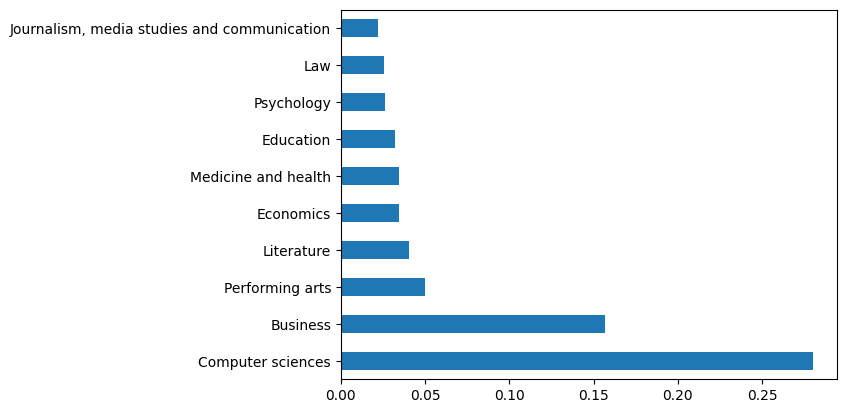

In [156]:
get_top_n_expertise(hs2_gpt4).normalize.plot.barh()

Total num of instances: 6164


<Axes: >

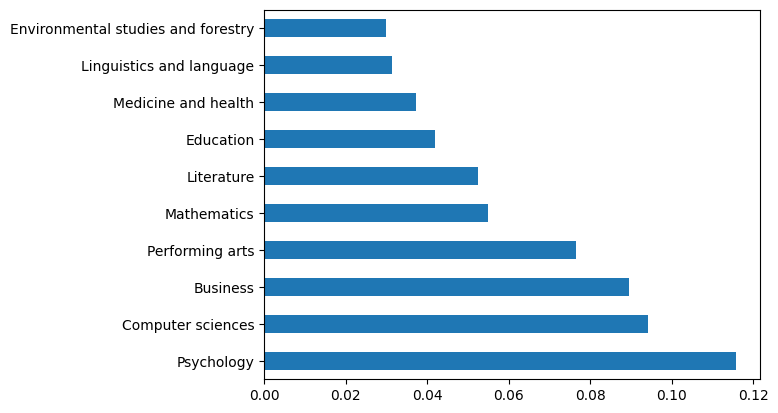

In [157]:
get_top_n_expertise(hs2_hums).normalize.plot.barh()

In [126]:
11 + 9 + 8 + 7 + 5 + 5 + 4

49

In [124]:
get_top_n_expertise(hs2_hums)

Total num of instances: 6164


,count,normalize
Psychology,714,0.115834
Computer sciences,581,0.094257
Business,552,0.089552
Performing arts,471,0.076411
Mathematics,339,0.054997
Literature,323,0.052401
Education,258,0.041856
Medicine and health,230,0.037313
Linguistics and language,194,0.031473
Environmental studies and forestry,185,0.030013


In [93]:
def get_multipref_soe_rankings(df):
    multipref_human_soe = [
        "Chemical engineering",
        "Religion",
        "Anthropology",
        "Chemistry",
        "Visual arts",
        "Earth sciences",
        "Space sciences",
    ]
    multipref_gpt4_soe = [
        "Logic",
        "Transportation",
        "Architecture and design",
        "Materials science and engineering",
        "Library and museum studies",
        "Media studies and communication",
        "Military sciences",
        "Family and consumer science",
    ]

    df_soe = (
        pd.DataFrame(
            [Counter([s for l in df.subject_of_expertise.to_list() for s in l])]
        )
        .T.sort_values(by=0, ascending=False)
        .reset_index()
        .rename(columns={0: "count", "index": "subject"})
    )

    return (
        df_soe[df_soe["subject"].isin(multipref_human_soe)].reset_index(drop=True),
        df_soe[df_soe["subject"].isin(multipref_gpt4_soe)].reset_index(drop=True),
    )

In [94]:
get_multipref_soe_rankings(hs2_gpt4)

(                subject  count
 0           Visual arts    128
 1              Religion    101
 2             Chemistry     80
 3        Space sciences     35
 4        Earth sciences     33
 5  Chemical engineering     27
 6          Anthropology     20,
                              subject  count
 0    Media studies and communication    105
 1            Architecture and design     88
 2                     Transportation     87
 3                              Logic     56
 4                  Military sciences     42
 5        Family and consumer science     27
 6  Materials science and engineering     18
 7         Library and museum studies      4)

In [95]:
get_multipref_soe_rankings(hs2_hums)

(                subject  count
 0           Visual arts     64
 1              Religion     54
 2        Earth sciences     45
 3             Chemistry     36
 4        Space sciences     23
 5          Anthropology     17
 6  Chemical engineering      9,
                              subject  count
 0    Media studies and communication     77
 1        Family and consumer science     68
 2                              Logic     58
 3            Architecture and design     46
 4                     Transportation     29
 5                  Military sciences     22
 6         Library and museum studies      8
 7  Materials science and engineering      4)

<Axes: ylabel='expertise_level'>

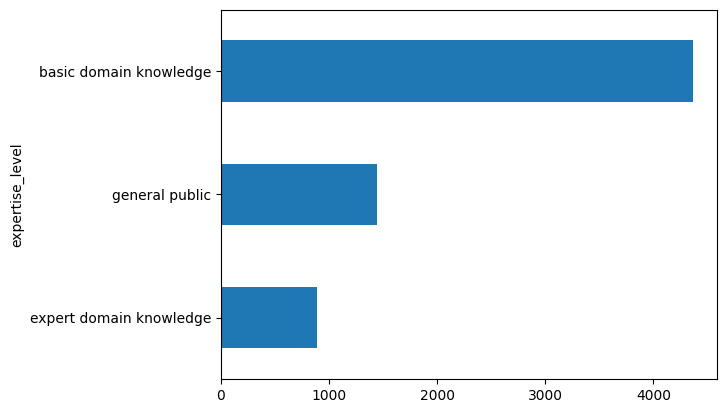

In [163]:
hs2_gpt4.expertise_level.value_counts()[
    ["expert domain knowledge", "general public", "basic domain knowledge"]
].plot.barh()

<Axes: ylabel='expertise_level'>

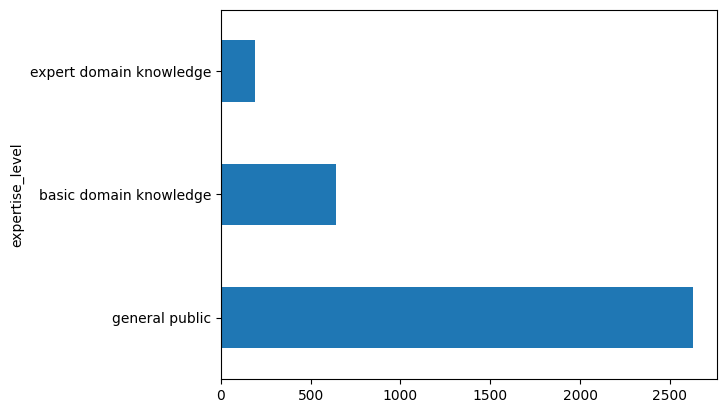

In [164]:
hs2_hums.expertise_level.value_counts().plot.barh()

In [127]:
hs2_gpt4.columns

Index(['id', 'text', 'response_a', 'response_b', 'pref_human', 'pref_gpt4',
       'rating_human', 'rating_gpt4', 'completions', 'subject_of_expertise',
       'expertise_level', 'languages', 'open_endedness', 'safety_concern',
       'complexity_of_intents', 'type_of_in_context_material',
       'format_constraints', 'cosine_sim', 'token_len_diff', 'rouge',
       'bertscore', 'len_longer', 'prompt_len', 'bertscore_length',
       'len_shorter', 'entity_sim'],
      dtype='object')

<Axes: >

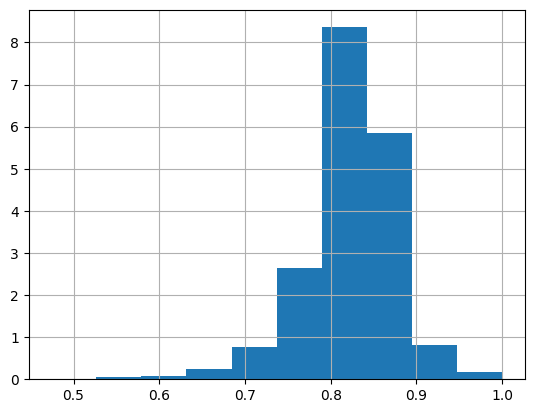

In [131]:
hs2_gpt4.bertscore.hist(density=True)

<Axes: >

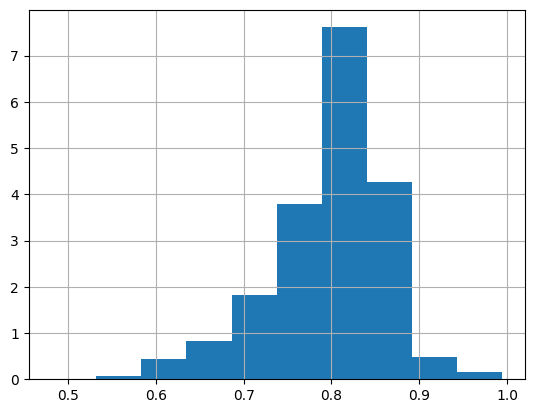

In [132]:
hs2_hums.bertscore.hist(density=True)

In [142]:
hs2_gpt4.open_endedness.value_counts(normalize=True)

open_endedness
moderate          0.496715
high              0.365482
low               0.115855
no                0.021798
safe area view    0.000149
Name: proportion, dtype: float64

In [143]:
hs2_hums.open_endedness.value_counts(normalize=True)

open_endedness
high        0.453784
moderate    0.342865
low         0.130849
no          0.072501
Name: proportion, dtype: float64

Text(0.5, 1.0, 'humans')

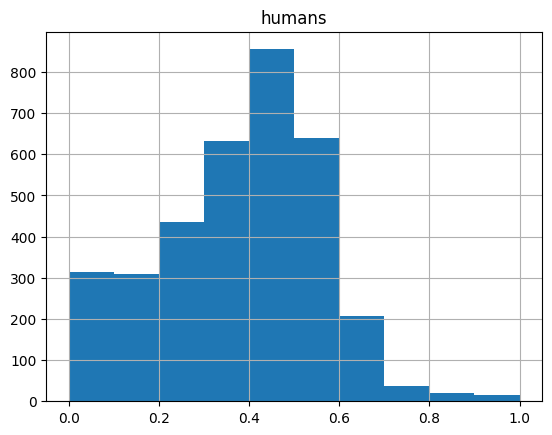

In [168]:
hs2_hums.rouge.hist()
plt.title("humans")

Text(0.5, 1.0, 'gpt-4')

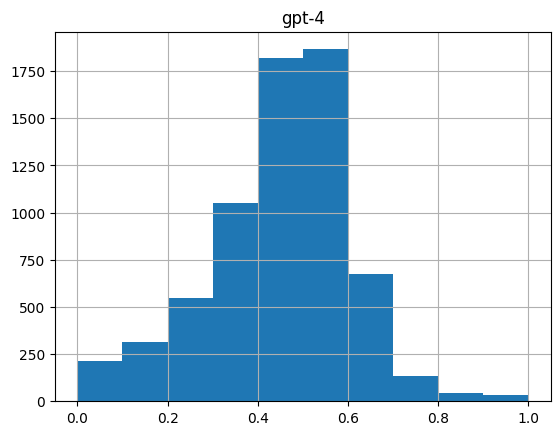

In [169]:
hs2_gpt4.rouge.hist()
plt.title("gpt-4")

<Axes: >

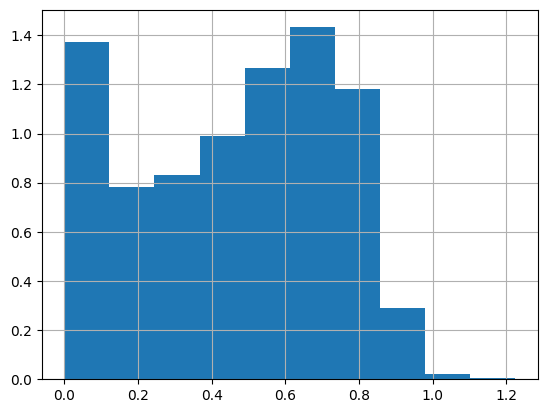

In [151]:
hs2_gpt4.bertscore_length.hist(density=True)

<Axes: >

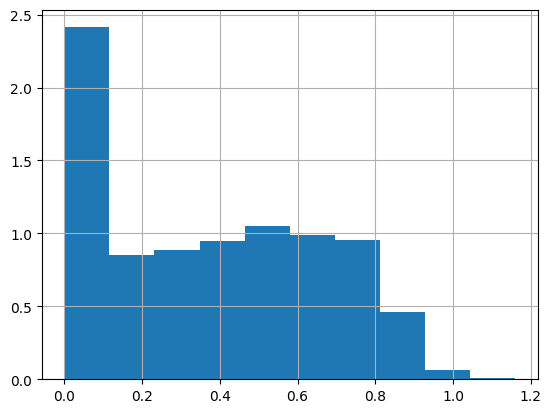

In [150]:
hs2_hums.bertscore_length.hist(density=True)

<Axes: >

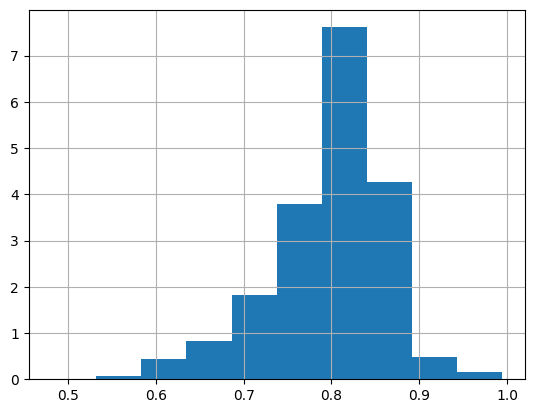

In [153]:
hs2_hums.bertscore.hist(density=True)

<Axes: >

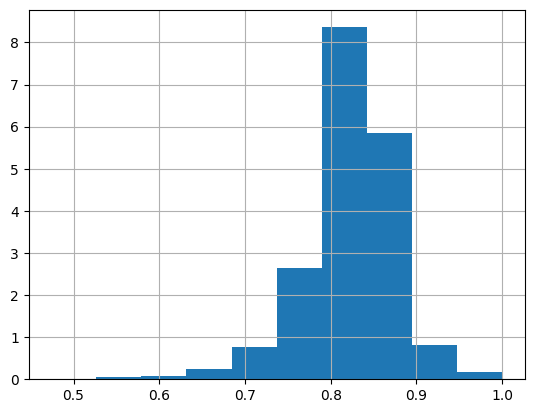

In [154]:
hs2_gpt4.bertscore.hist(density=True)